In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import ZoomFFT
from aotools.functions import phaseFromZernikes
# use `pip install aotools` to install the package


## 0. Define useful functions

In [5]:
def get_disk_mask(shape, radius, center=None):
    """
    Generate a binary mask with value 1 inside a disk, 0 elsewhere
    :param shape: list of integer, shape of the returned array
    :radius: integer, radius of the disk
    :center: list of integers, position of the center
    :return: numpy array, the resulting binary mask
    """
    if not center:
        center = (shape[0] // 2, shape[1] // 2)
    X, Y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    mask = (Y - center[0]) ** 2 + (X - center[1]) ** 2 < radius**2
    return mask.astype(int)


def complex_mask_from_zernike_coeff(shape, radius, center, vec):
    """
    Generate a complex phase mask from a vector containting the coefficient of the first Zernike polynoms.
    :param DMD_resolution: list of integers, contains the resolution of the DMD, e.g. [1920,1200]
    :param: integer, radius of the illumination disk on the DMD
    :center: list of integers, contains the position of the center of the illumination disk
    :center: list of float, the coefficient of the first Zernike polynoms
    """
    # Generate a complex phase mask from the coefficients
    zern_mask = np.exp(1j * phaseFromZernikes(vec, 2 * radius))
    # We want the amplitude to be 0 outside the disk, we fist generate a binary disk mask
    amp_mask = get_disk_mask([2 * radius] * 2, radius)
    # put the Zernik mask at the right position and multiply by the disk mask
    mask = np.zeros(shape=shape, dtype=complex)
    mask[
        center[0] - radius : center[0] + radius, center[1] - radius : center[1] + radius
    ] = (zern_mask * amp_mask)
    return mask


def get_cost(img, mask_radius=8):
    res = img[0].shape
    mask_center = [res[0] // 2, res[1] // 2]
    X, Y = np.meshgrid(np.arange(res[0]), np.arange(res[1]))
    # We generate a mask representing the disk we want to intensity to be concentrated in
    mask = (X - mask_center[0]) ** 2 + (Y - mask_center[1]) ** 2 < mask_radius**2
    signal = np.sum((img) * mask) / np.sum(mask)
    noise = np.sum((img) * (1.0 - mask)) / np.sum(1.0 - mask)
    cost = signal / noise
    return cost


## 1. Simulate aberrations of the DMD

Create a mask representing DMD aberrations. 
We use for the phase perturbation a sum of Zernike polynomials with random weight.
The first 3 Zernike polynomials are disregarded as justified in the article. 

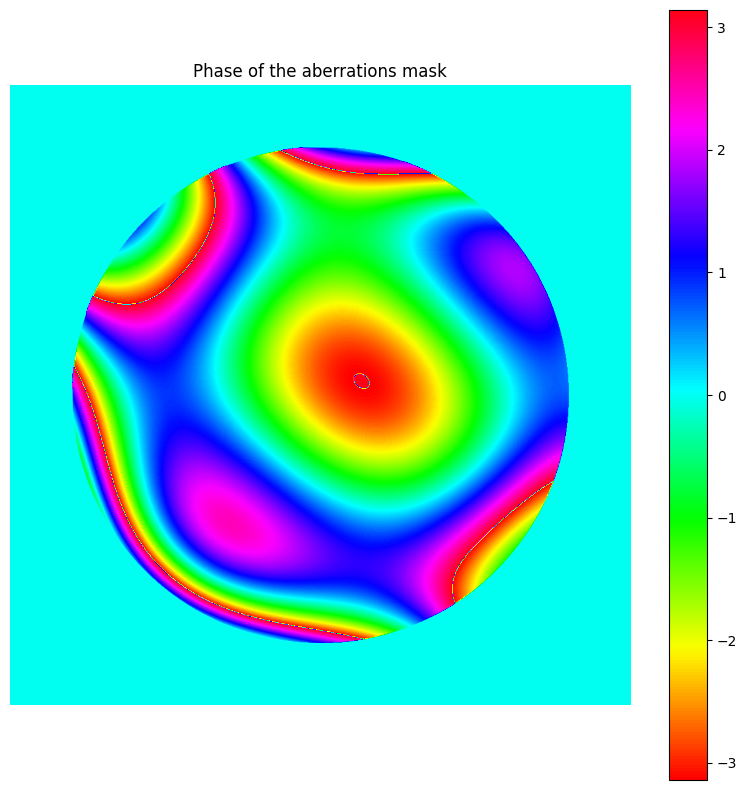

In [6]:
resolution = [1000, 1000]
center = [500, 500]
radius_illumination = 400
n_zernike_coeff = 11
n_zernike_coeff_to_0 = 3
zernike_max_amplitude = 1.
mask_input = get_disk_mask(resolution, 400, center)

# Weight of the Zernike polynoms
zernike_coeff_aberrations = [0]*n_zernike_coeff_to_0+(zernike_max_amplitude*2*(np.random.rand(n_zernike_coeff)-.5)).tolist()
# global phase mask
aberrations_mask = complex_mask_from_zernike_coeff(resolution, radius_illumination, center, zernike_coeff_aberrations)

plt.figure(figsize = (10,10))
plt.imshow(np.angle(aberrations_mask), cmap='hsv')
plt.axis('off')
plt.title('Phase of the aberrations mask')
plt.colorbar()

## 2. Simulation of the optimization

### 2.1 Parameters

In [7]:
# number of amplitude values to test for each Zernike polynom 
n_values_to_test = 30
# vector of amplitude values to test for each Zernike polynom
values = np.linspace(-zernike_max_amplitude,zernike_max_amplitude,n_values_to_test)
# number of times we will repeat the optimization for each Zernike polynom
n_repeat = 3

### 2.2 Simulate far field intensity pattern for a given phase wavefront displayed on the modulator

Text(0.5, 1.0, 'PSF of the optical system before correction')

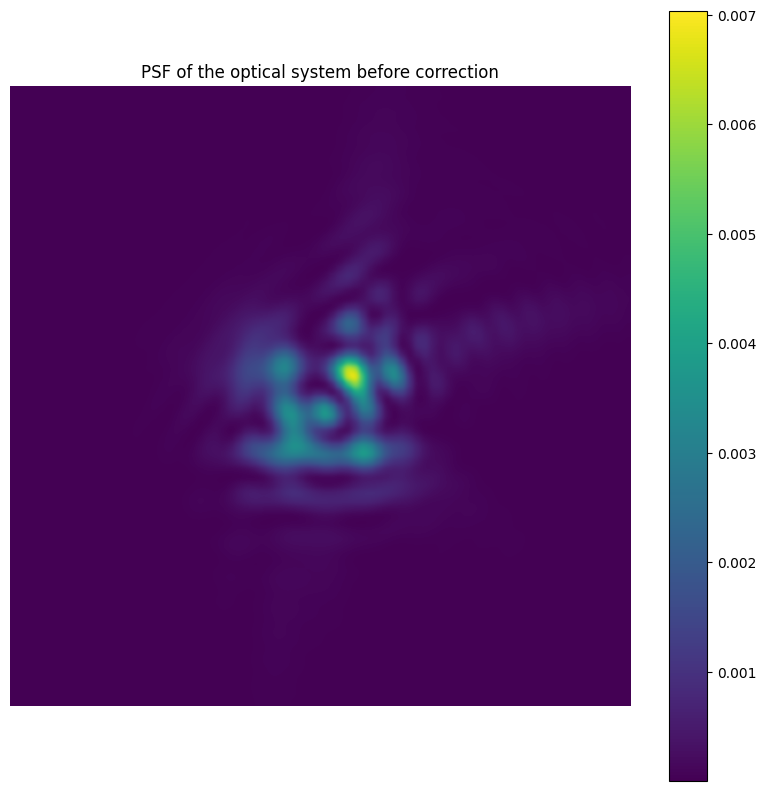

In [8]:
res_focus = 80


def ZoomFFT2D(A, m, fmax):
    """
    use ZoomFFT to perform a fast computation of the 2D FFT
    only in a given window.
    Note that the phase is wrong because of an offset of the direct plane field, 
    it is not a problem for the computation of the intensity.
    """
    n = A.shape[0]
    f = ZoomFFT(n, m=m, fn=[-fmax, fmax])
    FFT = f(A, axis=0)
    FFT = f(FFT, axis=1)
    return FFT


peak_center = np.zeros_like(aberrations_mask)
peak_center[center[0], center[1]] = 1


def focus(A):
    """
    Simulate the far field intensity pattern by computing the 2D FFT.
    """
    FT = ZoomFFT2D(A, fmax=0.03, m=res_focus)
    FT = np.abs(FT) ** 2 / np.sum(np.abs(FT) ** 2)
    return FT


# FTref = FFT(peak_center)
# FFT2 = lambda A: FFT(A)

FT = focus(aberrations_mask)

plt.figure(figsize=(10, 10))
plt.imshow(np.abs(FT), interpolation="gaussian")
plt.colorbar()
plt.axis("off")
plt.title("PSF of the optical system before correction")

### 2.3 Define a cost function to optimize

**Steps:**
1. Create a mask $M$ for about the size of a speckle grain centered around the maximum of the PSF
2. Create a function that get the far field intensity pattern $I$ for a given vector of Zernike coefficients
3. Compute the cost function as $f = \left[{\sum M\times I}\right]/\left[{\sum(1-M)\times I}\right]$

In [9]:
mask_cost = get_disk_mask([res_focus]*2, 2)
inv_mask_cost = 1-mask_cost

def get_focus(vec):
    full_vec = [0]*n_zernike_coeff_to_0+vec
    phase_modulation = complex_mask_from_zernike_coeff(resolution, radius_illumination, center, full_vec)
    total_phase = phase_modulation*aberrations_mask
    img = focus(total_phase)
    return img

def get_cost(vec):
    img = get_focus(vec)
    return np.sum(img*mask_cost)/np.sum(inv_mask_cost*img)

### 2.4 Optimization using a simple local sequential optimization 

#### Optimization loop

In [9]:
# intitial guess
vec_coeff = [0] * n_zernike_coeff


for _ in range(n_repeat):
    for ind_zernike in range(n_zernike_coeff):
        best_cost = 0
        for coeff_value in values:
            vec_coeff[ind_zernike] = coeff_value
            cost = get_cost(vec_coeff)
            if cost > best_cost:
                best_cost = cost
                best_vec = vec_coeff.copy()
        vec_coeff = best_vec.copy()

/tmp/ipykernel_78566/2282102113.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.int)
/tmp/ipykernel_78566/2282102113.py:29: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(

#### Show results

/tmp/ipykernel_757813/2282102113.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.int)
/tmp/ipykernel_757813/2282102113.py:29: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zero

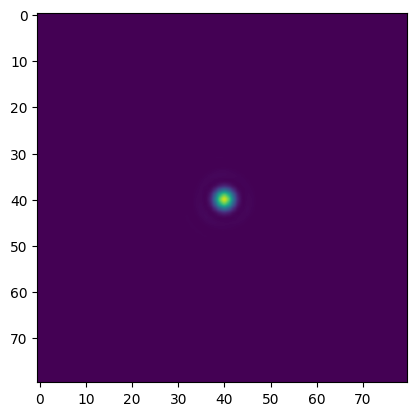

In [ ]:
def get_focus(vec):
    full_vec = [0]*n_zernike_coeff_to_0+vec
    phase_modulation = complex_mask_from_zernike_coeff(resolution, radius_illumination, center, full_vec)
    total_phase = phase_modulation*aberrations_mask
    img = focus(total_phase)
    return img
I = get_focus(vec_coeff)
plt.figure()
plt.imshow(I, interpolation='gaussian')
plt.axis('off')
plt.title('Optimized PSF')

### 2.5 Optimization with EasyOptimization: [github.com/wavefrontshaping/EasyOptimization](https://github.com/wavefrontshaping/EasyOptimization)

Install with:
```bash
pip install git+https://gitlab.institut-langevin.espci.fr/spopoff/EasyOptimization.git
```

In [10]:
from EasyOptim import (
    EasyPartition, 
    EasyIteration, 
    register_data,
    register_current_data
)

In [15]:
# create the algoithm object
myalgo = EasyIteration(
    n_var = n_zernike_coeff,
    min_or_max = 'max',
    n_repeat = n_repeat)

# register the function to optimize
# EasyOptim want a function that returns both the value to optimize
# and the data we want to save, here nothing but we could for instance
# save the patterns at each iteration
cost = lambda vec: (get_cost(vec), {}) 
myalgo.register_callback(cost)

initial_guess = [0] * n_zernike_coeff

#### Run optimization

In [17]:
best_value, opt_coeffs, data = myalgo.run(
    values = values,
    x_init = initial_guess)

Repeat: 1/3 | Iter: 11/11 | Cost = 0.3662: 100%|██████████| 11/11 [08:04<00:00, 44.03s/it]
Repeat: 2/3 | Iter: 11/11 | Cost = 0.8817: 100%|██████████| 11/11 [07:53<00:00, 43.03s/it]
Repeat: 3/3 | Iter: 11/11 | Cost = 0.9229: 100%|██████████| 11/11 [08:32<00:00, 46.62s/it]


#### Show results

Text(0.5, 1.0, 'Optimized PSF')

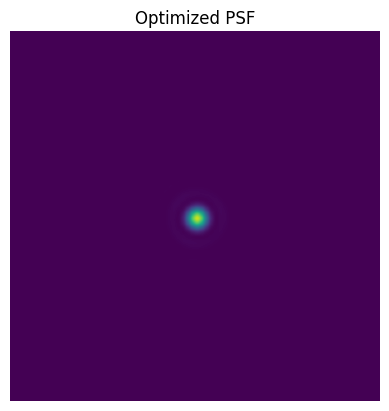

In [20]:
I = get_focus(opt_coeffs)
plt.figure()
plt.imshow(I, interpolation='gaussian')
plt.axis('off')
plt.title('Optimized PSF')

Text(0.5, 1.0, 'Evolution of the cost function during the optimization')

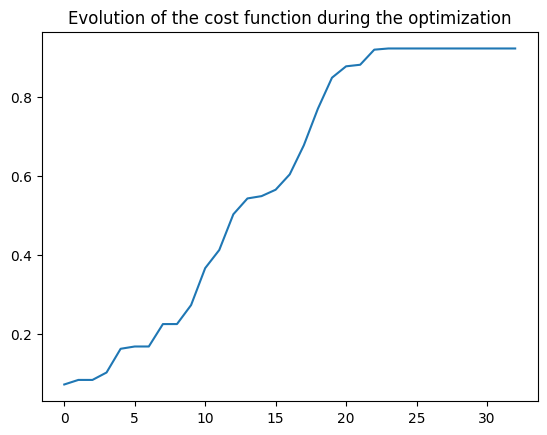

In [21]:
plt.figure()
plt.plot(myalgo.evol)
plt.title('Evolution of the cost function during the optimization')